In [1]:
import json
import string
import pickle
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [2]:
with open('annotations/captions_train2014.json') as f:
    train_caption_data = json.load(f)

In [7]:
train_caption_data['annotations'][67876]

{'image_id': 223984,
 'id': 61620,
 'caption': "An older brick building in the background of a don't walk sign."}

In [4]:
image_id = {}
id_image = {}
for item in train_caption_data['images']:
    image_name = item['file_name']
    id =item['id']
    image_id[image_name] = id
    id_image[id] = image_name

In [104]:
raw_caption_dict = {}
for item in train_caption_data['annotations']:
    id = item['image_id']
    caption = item['caption']
    if id_image[id] in raw_caption_dict:
        raw_caption_dict[id_image[id]].append(caption)
    else:
        raw_caption_dict[id_image[id]] = [caption]

In [105]:
raw_caption_dict['COCO_train2014_000000057870.jpg']

['A restaurant has modern wooden tables and chairs.',
 'A long restaurant table with rattan rounded back chairs.',
 'a long table with a plant on top of it surrounded with wooden chairs ',
 'A long table with a flower arrangement in the middle for meetings',
 'A table is adorned with wooden chairs with blue accents.']

In [106]:
caption_dict = {}
for image, captions in raw_caption_dict.items():
    new_captions = []
    for caption in captions:
        translation = str.maketrans('', '', string.punctuation)
        caption = caption.translate(translation)
        words = caption.split()
        words = [word.lower() for word in words]
        words = [word for word in words if word.isalpha()]
        words = ' '.join(words)
        words = 'startseq ' + words + ' endseq'
        if len(words):
            new_captions.append(words)
    caption_dict[image] = new_captions

In [107]:
caption_dict['COCO_train2014_000000057870.jpg']

['startseq a restaurant has modern wooden tables and chairs endseq',
 'startseq a long restaurant table with rattan rounded back chairs endseq',
 'startseq a long table with a plant on top of it surrounded with wooden chairs endseq',
 'startseq a long table with a flower arrangement in the middle for meetings endseq',
 'startseq a table is adorned with wooden chairs with blue accents endseq']

In [108]:
all_words = []
lens = []
count_dict = {}

for captions in caption_dict.values():
    for caption in captions:
        lens.append(len(caption.split()))
        _ = [all_words.append(word) for word in caption.split()]
raw_vocabulary = set(all_words)

for word in all_words:
    if word in count_dict:
        count_dict[word] += 1
    else:
        count_dict[word] = 1
        
        
with open('glove_embeddings/glove.6B.300d.txt', 'r') as f:
    raw_glove_data = f.read()

glove_embedding_matrix = {}
for line in tqdm(raw_glove_data.split('\n')[:-1]):
    word = line.split()[0]
    embedding = np.asarray(line.split()[1:], dtype=np.float32)
    glove_embedding_matrix[word] = embedding
glove_embedding_matrix['startseq'] = np.random.normal(size=(300,))
glove_embedding_matrix['endseq'] = np.random.normal(size=(300,))

with open('glove_embedding_matrix', 'wb') as f:
    pickle.dump(glove_embedding_matrix, f)

100%|██████████| 400000/400000 [00:20<00:00, 19408.98it/s]


In [111]:
high_freq_words = [word for word, count in count_dict.items() if count > 2 and word in glove_embedding_matrix]

print(f'Total words in dataset : {len(all_words)}')
print(f'Word count in vocalubary : {len(raw_vocabulary)}')
print(f'Words with frequency more than 4 : {len(high_freq_words)}')
print(f'Maximum length of caption : {max(lens)}')

Total words in dataset : 5156796
Word count in vocalubary : 24384
Words with frequency more than 4 : 10970
Maximum length of caption : 51


In [112]:
word_idx = {word:idx+1 for idx, word in enumerate(high_freq_words)}
idx_word = {idx+1:word for idx, word in enumerate(high_freq_words)}

with open('wordtoidx.pkl', 'wb') as f:
    pickle.dump(word_idx, f)

def wordtoidx(word:str):
    idx = word_idx[word]
    return idx

def idxtoword(idx:int):
    if idx == 0:
        return ''
    word = idx_word[idx]
    return word

In [119]:
image_name = []
partial_captions = []
next_words = []
max_len = -1
vocab_size = len(high_freq_words)

train_images = list(image_id.keys())
for image in train_images:
    captions = caption_dict[image]
    for caption in captions:
        words = [word for word in caption.split() if word in high_freq_words]
        for idx in range(1, len(words)):
            partial_caption = ' '.join(words[:idx])
            if max_len < len(words[:idx]):
                max_len = len(words[:idx])
            partial_captions.append(partial_caption)
            next_words.append(words[idx])
            image_name.append(image)

train_data = {
    'image_name' : image_name,
    'partial_captions' : partial_captions,
    'next_words' : next_words
}
df = pd.DataFrame.from_dict(train_data)
df.to_csv('train_data.csv', index=False)

In [127]:
df.loc[df['image_name'] == 'COCO_train2014_000000057870.jpg'][['partial_captions', 'next_words']]

,partial_captions,next_words
0,startseq,a
1,startseq a,restaurant
2,startseq a restaurant,has
3,startseq a restaurant has,modern
4,startseq a restaurant has modern,wooden
5,startseq a restaurant has modern wooden,tables
6,startseq a restaurant has modern wooden tables,and
7,startseq a restaurant has modern wooden tables...,chairs
8,startseq a restaurant has modern wooden tables...,endseq
9,startseq,a


In [128]:
print(f'Vocab size = {vocab_size}')
print(f'Max Sequence length = {max_len}')

Vocab size = 10970
Max Sequence length = 50


In [129]:
encoded_partial_captions = []
encoded_next_words = []
for partial, next_word in zip(partial_captions, next_words):
    encoded_partial = [wordtoidx(word) for word in partial.split()]
    encoded_partial_captions.append(np.array(encoded_partial))
    encoded_next_words.append(wordtoidx(next_word))
image_name = np.array(image_name)
encoded_partial_captions = np.array(pad_sequences(encoded_partial_captions, maxlen=max_len, padding='post'))
encoded_next_words = np.array(encoded_next_words)

startseq a restaurant has modern wooden tables and chairs                                         
endseq


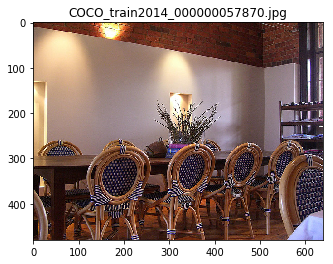

In [132]:
i = 8
image, caption = image_name[i], encoded_partial_captions[i] 
caption = [idxtoword(idx) for idx in caption]
next_word = idxtoword(encoded_next_words[i])
img = cv2.imread(f'images/train2014/{image}')
plt.imshow(img[:,:,::-1])
plt.title(image)
print(*caption)
print(next_word)

In [133]:
np.save('encoded_partial_captions.npy', encoded_partial_captions)
np.save('image_names', image_name)
np.save('next_words.npy', encoded_next_words)